<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h2>Mixture Density Networks (MDN) for distribution and uncertainty estimation </h2>

This material is copyright Axel Brando and made available under the Creative Commons Attribution-ShareAlike 4.0 International License (http://creativecommons.org/licenses/by-sa/4.0/). Code is also made available under the Apache Version 2.0 License (https://www.apache.org/licenses/LICENSE-2.0). 

Please, to use this material and code follow the instructions explained in the main repository [https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation](https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation#bibtex-reference-format-for-citation)

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>Time series regression problem by using DNN with Adversarial Training</h3>

In [1]:
import tensorflow as tf
tf.python.control_flow_ops = tf

#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.Session(config=config)

from keras import backend as K

import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import random
from datetime import datetime

Using TensorFlow backend.


### We load our dataset
Because our dataset is private we will only expose a dummy code

In [3]:
X = np.load('Normalised-X_train.npy')
y = np.load('y_train.npy')
X_val = np.load('Normalised-X_val.npy')
y_val = np.load('y_val.npy')
X_orig = np.load('Original-X_train.npy')
X_val_orig = np.load('Original-X_val.npy')

In [5]:
from keras.models import Sequential,Graph
from keras.layers.core import Dense, Dropout
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.models import model_from_json
from keras.regularizers import l2, activity_l2

from keras.objectives import mean_absolute_error

from keras import backend as K

import numpy as np

c = 1 #The number of outputs we want to predict
m = 1 #The number of distributions we want to use in the mixture

#Note: The output size will be (c + 2) * m

def log_sum_exp(x, axis=None):
    """Log-sum-exp trick implementation"""
    x_max = K.max(x, axis=axis, keepdims=True)
    return K.log(K.sum(K.exp(x - x_max), 
                       axis=axis, keepdims=True))+x_max


def mean_log_Gaussian_like(y_true, parameters):
    """Mean Log Gaussian Likelihood distribution
    Note: The 'c' variable is obtained as global variable
    """
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    alpha = components[:, c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-8,1.))
    
    exponent = K.log(alpha) - .5 * float(c) * K.log(2 * np.pi) \
    - float(c) * K.log(sigma) \
    - K.sum((K.expand_dims(y_true,2) - mu)**2, axis=1)/(2*(sigma)**2)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res


def mean_log_LaPlace_like(y_true, parameters):
    """Mean Log Laplace Likelihood distribution
    Note: The 'c' variable is obtained as global variable
    """
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    alpha = components[:, c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-2,1.))
    
    exponent = K.log(alpha) - float(c) * K.log(2 * sigma) \
    - K.sum(K.abs(K.expand_dims(y_true,2) - mu), axis=1)/(sigma)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res


def scoring_rule_adv(y_true, y_pred):
    """Fast Gradient Sign Method (FSGM) to implement Adversarial Training
    Note: The 'graphADV' pointer is obtained as global variable
    """
    
    # Compute loss 
    #Note: Replace with 'mean_log_Gaussian_like' if you want a Gaussian kernel.
    error = mean_log_LaPlace_like(y_true, y_pred)
    
    # Craft adversarial examples using Fast Gradient Sign Method (FGSM)
    # Define gradient of loss wrt input
    grad_error = K.gradients(error,graphADV.input) #Minus is on error function
    # Take sign of gradient, Multiply by constant epsilon, Add perturbation to original example to obtain adversarial example
    #Sign add a new dimension we need to obviate
    
    epsilon = 0.08
    
    adversarial_X = K.stop_gradient(graphADV.input + epsilon * K.sign(grad_error)[0])
    
    # Note: If you want to test the variation of adversarial training 
    #  proposed by XX, eliminate the following comment character 
    #  and comment the previous one.
    
    ##adversarial_X = graphADV.input + epsilon * K.sign(grad_error)[0]
    
    adv_output = graphADV(adversarial_X)
    
    #Note: Replace with 'mean_log_Gaussian_like' if you want a Gaussian kernel.
    adv_error = mean_log_LaPlace_like(y_true, adv_output)
    return 0.3 * error + 0.7 * adv_error

graph = Graph()
graph.add_input(name='input', input_shape=(12,))
graph.add_node(Dense(500, activation='relu'), name='dense1_1', input='input')
graph.add_node(Dropout(0.25), name='drop1_1', input='dense1_1')

graph.add_node(Dense(500, activation='relu'), name='dense2_1', input='drop1_1')
graph.add_node(Dropout(0.25), name='drop2_1', input='dense2_1')

graph.add_node(Dense(500, activation='relu'), name='dense3_1', input='drop2_1')
graph.add_node(Dropout(0.25), name='drop3_1', input='dense3_1')


graph.add_node(Dense(output_dim=500, activation="relu"), name='FC1', input='drop3_1')
graph.add_node(Dense(output_dim=c*m), name='FC_mus', input='FC1')
graph.add_node(Dense(output_dim=m, activation=elu_modif), name='FC_sigmas', input='FC1') #K.exp, W_regularizer=l2(1e-3)
graph.add_node(Dense(output_dim=m, activation='softmax'), name='FC_alphas', input='FC1')
graph.add_output(name='output', inputs=['FC_mus','FC_sigmas', 'FC_alphas'], merge_mode='concat',concat_axis=1)
graphADV = graph
graph.compile('rmsprop', {'output':scoring_rule_adv})

In [6]:
from keras.callbacks import Callback, ModelCheckpoint
class LossHistoryDAdvDMDN3(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
lossHistory = LossHistory()

In [7]:
from datetime import datetime
start_time = datetime.now()
epoch=500
graph.fit(data={'input':X.squeeze(),'output':y}, batch_size=100000, nb_epoch=epoch, 
          validation_split=0.1,callbacks=[lossHistory])
end_time = datetime.now()
a=0
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

Train on 1350000 samples, validate on 150000 samples
Epoch 1/500
1350000/1350000 [==============================] - 16s - loss: 29.7862 - val_loss: 9.0249
Epoch 2/500
1350000/1350000 [==============================] - 15s - loss: 7.8454 - val_loss: 7.2621
Epoch 3/500
1350000/1350000 [==============================] - 15s - loss: 6.9666 - val_loss: 6.8823
Epoch 4/500
1350000/1350000 [==============================] - 15s - loss: 6.7584 - val_loss: 6.7566
Epoch 5/500
1350000/1350000 [==============================] - 15s - loss: 6.6692 - val_loss: 6.6874
Epoch 6/500
1350000/1350000 [==============================] - 15s - loss: 6.6185 - val_loss: 6.6641
Epoch 7/500
1350000/1350000 [==============================] - 15s - loss: 6.5885 - val_loss: 6.6248
Epoch 8/500
1350000/1350000 [==============================] - 15s - loss: 6.5699 - val_loss: 6.6047
Epoch 9/500
1350000/1350000 [==============================] - 15s - loss: 6.5517 - val_loss: 6.6078
Epoch 10/500
1350000/1350000 [=======

In [17]:
#dummy code
graph.load_weights('MDN-weights.hdf5')

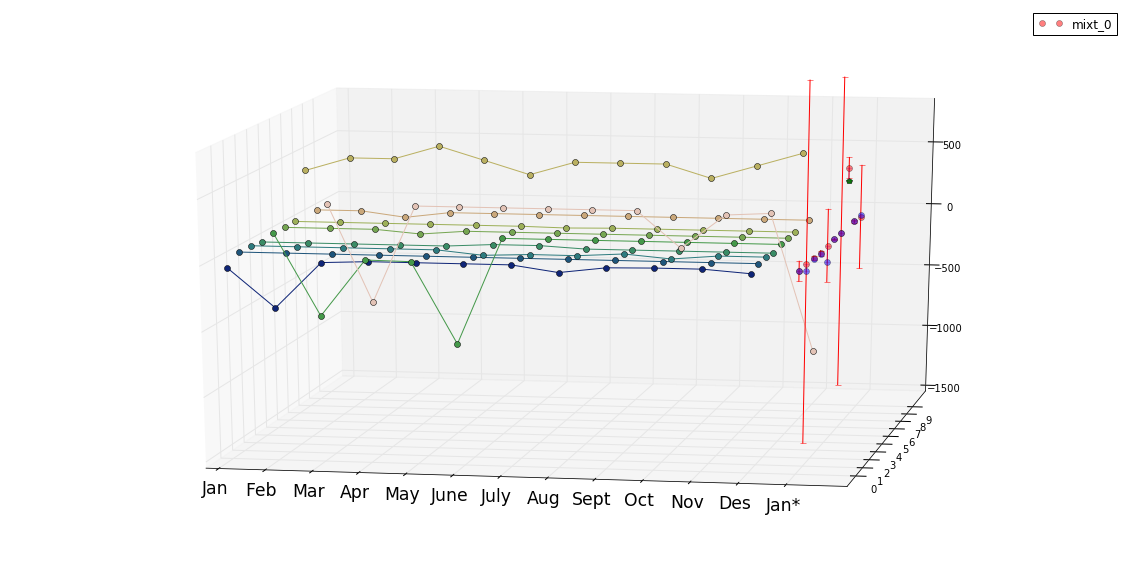

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

c=1
m=1

parameters = graphDAdvDMDN3.predict(data={'input':X_val[start:start+rang].squeeze()})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

thr_alpha = 0.5

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

cont = []
cont_const = []
const = 100
guany_sig = []
erSigConst = np.zeros((2,rang))


color = cm.gist_earth(np.linspace(0, 1, rang+2))

for elem in xrange(rang):
    ax.plot(xs=np.arange(12),ys=[elem]*12,zs=X_val_orig[start+elem,:,0].reshape(-1), c=color[elem+1], marker='o')

zerror = 500

  
for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        if alpha_pred[i,mx] > thr_alpha:
            ax.plot([12, 12], [i, i], [mu_pred[i,0,mx]-np.sqrt(2)*sigma_pred[i,mx],
                                       mu_pred[i,0,mx]+np.sqrt(2)*sigma_pred[i,mx]], 
                    marker="_", c=col[mx], alpha=alpha_pred[i,mx])
            y_pred[i] = mu_pred[i,0,mx]
            #In order to avoid ERROR of 0.1 when approx 0, we add a margin of 0.1€
            if mu_pred[i,0,mx]+np.sqrt(2)*sigma_pred[i,mx]+0.1<y_val[start+i] or mu_pred[i,0,mx]-np.sqrt(2)*sigma_pred[i,mx]-0.1>y_val[start+i]:
                cont += [i]
                if mu_pred[i,0,mx]+const<y_val[start+i] or mu_pred[i,0,mx]-const>y_val[start+i]:
                    guany_sig += [const-np.sqrt(2)*sigma_pred[i,mx]-0.1]
                    cont_const += [i]
                else:
                    guany_sig += [np.sqrt(2)*sigma_pred[i,mx]+0.1-const]
            elif mu_pred[i,0,mx]+const<y_val[start+i] or mu_pred[i,0,mx]-const>y_val[start+i]:
                cont_const += [i]
                guany_sig += [const-np.sqrt(2)*sigma_pred[i,mx]-0.1]
            
            erSigConst[0,i] = np.sqrt(2)*sigma_pred[i,mx]+0.1 - np.abs(mu_pred[i,0,mx]-y_val[start+i])
            erSigConst[1,i] = const - np.abs(mu_pred[i,0,mx]-y_val[start+i])
    
    tmp = alpha_pred[:,mx]>thr_alpha
    if np.sum(tmp) > 0:
        ax.plot([12]*rang,np.arange(rang)[tmp],
                    y_pred[tmp], color=col[mx],
                    linewidth=1, marker='o', linestyle=' ',
                    alpha=0.5, label='mixt_'+str(mx))
    else:
        print "Distribution",mx," has always alpha below",thr_alpha
        
for point in xrange(rang):
    if point in cont:
        ax.plot(xs=12, ys=point,zs=y_val[start+point], 
                color='green', linewidth=1, marker='p', 
                linestyle=' ',alpha=1)
    else:
        ax.plot(xs=12, ys=point,zs=y_val[start+point], 
                color='blue', linewidth=1, marker='o', 
                linestyle=' ',alpha=0.5)
    ax.plot(xs=[12, 12], ys=[point, point],zs=[y_val[start+point],y_pred[point]],
            marker="_", alpha = 0.4, color = 'purple')


ax.xaxis.set_ticks(range(13))
ax.xaxis.set_ticklabels(['Jan','Feb','Mar','Apr',
                    'May','June','July','Aug',
                    'Sept','Oct','Nov','Des','Jan*'])
ax.xaxis.set_tick_params(labelsize='xx-large')
ax.yaxis.set_ticks(range(rang))


ax.set_xlim3d(0, 13)
ax.set_ylim3d(-1, rang+1)
ax.set_zlim3d(-1500, 800)
ax.view_init(15, -80)

plt.gcf().set_size_inches((20,10))
plt.legend()
plt.show()

In [13]:
#y_pred = model.predict(X_val)['output']
from datetime import datetime
start_time = datetime.now()
y_pred = graph.predict(data={'input':X_val.squeeze()})['output']
end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  Prediction ends  *********************************

Duration: 0:00:28.994437



*********************************  Prediction ends  *********************************

Duration: 0:00:03.392599
Elements below tolerance: 937641
Mean Absolute Error:  113.59279267
Mean Squared Error:  9055483.09071
Root Mean Squared Error:  3009.23297382
Maximum Total Error:  [ 1459237.66311133](real: [-1459236.], predicted: [ 1.66311133])
AE 10% 0.516293676637 (829068)

*********************************  End  *********************************

Duration: 0:00:00.440633


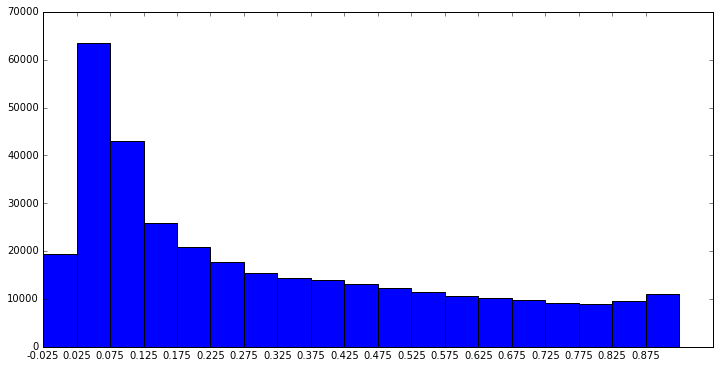

In [14]:
from datetime import datetime
start_time = datetime.now()
c=1
m=1
comp = np.reshape(y_pred,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
alpha_pred=alpha_pred.argmax(axis=1)
y_pred = np.array([mu_pred[i,:,alpha_pred[i]] for i in xrange(len(mu_pred))])


end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

from datetime import datetime
start_time = datetime.now()
import matplotlib.pyplot as plt
%matplotlib inline
tolerance = 1e-1
idx = np.where(np.abs(y_pred-y_val)>tolerance)[0]

print 'Elements below tolerance: ' + str(len(idx))

measure = np.mean(np.abs((y_pred-y_val*1.)))
print 'Mean Absolute Error:  ' + str(measure) 
measure = np.mean(np.power((y_pred-y_val*1.),2))
print 'Mean Squared Error:  ' + str(measure) 
measure = np.sqrt(measure)
print 'Root Mean Squared Error:  ' + str(measure) 
i = np.argmax(np.abs((y_pred-y_val*1.)))
measure = np.abs((y_pred[i]-y_val[i]*1.))
print 'Maximum Total Error:  ' + str(measure) + '(real: ' + str(y_val[i]) + ', predicted: ' + str(y_pred[i]) + ')'

measure = np.abs((y_pred[idx]-y_val[idx]))/(np.abs(y_val[idx])+1e-16)
MAE10 = np.where(measure>0.1)[0]
print 'AE 10% ' + str(1.*len(MAE10)/len(y_val)) + ' (' + str(len(MAE10)) + ')'

bins = np.arange(0,1.0,0.05)-0.025
measure = np.abs(y_pred[idx]-y_val[idx])/(np.abs(y_val[idx])+1e-16)
[dat, bins] = np.histogram(measure,bins=bins)
plt.bar(np.arange(len(dat)),dat,width =1)
plt.xticks(np.arange(len(dat)),bins[:-1])
plt.gcf().set_size_inches((10,6))

plt.gcf().set_size_inches((12,6))
 
end_time = datetime.now()
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))